In [101]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


import sys
sys.path.append('../Utilities/')

from tqdm.notebook import tqdm

import importlib
import data_utils
importlib.reload(data_utils)

## Import MDS from sklearn
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt


In [4]:
class UNet1D(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, num_layers=2):
        super(UNet1D, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.depth = depth
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.num_start_filters = 32

        self._create_unet(self.in_channels, self.num_start_filters)

        self.encoder_output_shape = int(np.floor(300/(2**depth)))
        self.encoder_feature_maps = int(self.num_start_filters * 2 ** (self.depth - 1))

        # self.bottleneck = self.create_linear_bottleneck((self.encoder_output_shape, self.encoder_feature_maps))
        self.bottleneck = nn.Sequential(
            nn.Conv1d(self.encoder_feature_maps, 2 * self.encoder_feature_maps, kernel_size=1, padding=0),
            nn.ReLU()
        )

        self.logits = nn.Conv1d(self.num_start_filters, self.out_channels, 1, 1)

    def create_linear_bottleneck(self, shape):
        in_channels = shape[1]
        out_channels = shape[1] * 2

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels * shape[0], out_channels* shape[0]),
            nn.ReLU())

    def _create_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU()
        )

    def _create_decoder_block(self, in_channels, out_channels):
        return nn.ModuleList([nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU()])

    def _create_unet(self, in_channels, out_channels):
        for _ in range(self.depth):
            self.encoder.append(self._create_encoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels*2

        out_channels = in_channels
        in_channels = in_channels * 2
        for _ in range(self.depth):
            self.decoder.append(self._create_decoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels//2

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x = enc(x)
            encoded.append(x)
            x = nn.MaxPool1d(kernel_size=2, stride=2)(x)
            
        x = self.bottleneck(x)  # Bottleneck layer
        # x = torch.reshape(x, (-1, self.encoder_feature_maps*2, self.encoder_output_shape))


        for dec in self.decoder:
            ## Adding input with encoder concatenation
            enc_output = encoded.pop()
            x = dec[0](x)
            ## Pad the decoder output to match the encoder output
            diff = enc_output.shape[2] - x.shape[2]
            x = F.pad(x, (diff // 2, diff - diff // 2))
            x = torch.cat((enc_output, x), dim=1)
            x = dec[1](x)
            x = dec[2](x)
        ## Add softmax to logits
        # x = self.softmax(x)

        return self.logits(x)

input_channels = 6 
output_channels = 1
depth = 3
num_layers = 2

model = UNet1D(input_channels, output_channels, depth, num_layers)
# print(model)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [6]:
# Generate synthetic data
num_superpixels = 300
num_features = 6
synthetic_data = np.random.rand(num_superpixels, num_features)
synthetic_data = torch.tensor(synthetic_data, dtype=torch.float32)

#Reshape
synthetic_data = synthetic_data.unsqueeze(0).transpose(1, 2)

# Pass the synthetic data through the U-Net model
with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating LightningModule 

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = dice_loss + BCE
        
        return Dice_BCE

In [11]:
class CloudSegmentationModel(pl.LightningModule):
    def __init__(self, depth=2):
        super(CloudSegmentationModel, self).__init__()
        self.unet = UNet1D(in_channels=6, out_channels=1, depth=depth)
        
    def forward(self, x):
        return nn.Sigmoid()(self.unet(x))

    def accuracy_score(self, y_true, y_pred):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = np.where(y_pred > 0.5, 1, 0)
        return accuracy_score(y_true, y_pred)

    def training_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = nn.BCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = nn.BCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [12]:
model = CloudSegmentationModel()
print("Parameters: ",count_parameters(model))

with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Parameters:  91521
Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating Dataset

In [13]:
patches,mask = data_utils.get_patch(path_to_folders_images = "../Dataset/Natural_False_Color/", path_to_folders_labels = "../Dataset/Entire_scene_gts/")

c:\Users\GP65\anaconda3\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [53]:
X = np.load('../Dataset/X_pca.npy')
y = np.load('../Dataset/Y_pca.npy')
raw = np.load('../Dataset/raw.npy')
slic_map = np.load('../Dataset/slic_map_pca.npy')
original_ordering = np.load('../Dataset/original_ordering_pca.npy', allow_pickle=True)

In [57]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_item = torch.tensor(self.X[idx], dtype=torch.float32).T
        y_item = torch.tensor(self.y[idx], dtype=torch.float32).T
        return x_item, y_item

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = CustomDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [58]:
## Divide X and Y into train and test sets
np.random.seed(42)
test_index = np.random.choice(range(len(X)), size=200, replace=False)
train_index = [i for i in range(len(X)) if i not in test_index]

X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

In [59]:
train_loader = create_dataloader(X_train,y_train,batch_size=64,shuffle=True)
test_loader = create_dataloader(X_test,y_test,batch_size=64,shuffle=True)

## Training with PL

In [60]:
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

In [61]:
# Initialize the model and trainer
segmentationModel = CloudSegmentationModel(depth=2)

In [62]:
logger = TensorBoardLogger('lightning_logs/', name='sgd_tagger_std')

In [63]:
checkpoint_callback = ModelCheckpoint(
    dirpath = './/model_checkpt/',
    filename = 'best-checkpoint',
    save_top_k=1,
    verbose = True,
    monitor='val_loss',
    mode='min'
)

In [64]:
trainer = Trainer(
    logger = logger,
    gpus=1 if torch.cuda.is_available() else None,
    max_epochs=1000,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20), checkpoint_callback]
)

# Train the model using the trainer
trainer.fit(segmentationModel, train_loader, test_loader)


c:\Users\GP65\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\GP65\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory D:\Projects\ComputerVision_CloudSegmentation\Superpixel-UNET\model_checkpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | unet | UNet1D | 91.5 K
--------------------------------
91.5 K    Trainable params
0         Non-trainable params
91.5 K    Total param

c:\Users\GP65\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\GP65\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\GP65\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine

Epoch 0: 100%|██████████| 24/24 [00:00<00:00, 43.09it/s, loss=0.676, v_num=1]

Epoch 0, global step 20: 'val_loss' reached 0.65367 (best 0.65367), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 24/24 [00:00<00:00, 66.67it/s, loss=0.629, v_num=1]

Epoch 1, global step 40: 'val_loss' reached 0.57904 (best 0.57904), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 2: 100%|██████████| 24/24 [00:00<00:00, 64.00it/s, loss=0.575, v_num=1]

Epoch 2, global step 60: 'val_loss' reached 0.54719 (best 0.54719), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 3: 100%|██████████| 24/24 [00:00<00:00, 66.67it/s, loss=0.565, v_num=1]

Epoch 3, global step 80: 'val_loss' reached 0.54146 (best 0.54146), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 4: 100%|██████████| 24/24 [00:00<00:00, 76.43it/s, loss=0.532, v_num=1]

Epoch 4, global step 100: 'val_loss' reached 0.50910 (best 0.50910), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 5: 100%|██████████| 24/24 [00:00<00:00, 69.97it/s, loss=0.515, v_num=1]

Epoch 5, global step 120: 'val_loss' reached 0.49882 (best 0.49882), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 6: 100%|██████████| 24/24 [00:00<00:00, 74.30it/s, loss=0.468, v_num=1]

Epoch 6, global step 140: 'val_loss' reached 0.44290 (best 0.44290), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 7: 100%|██████████| 24/24 [00:00<00:00, 78.43it/s, loss=0.44, v_num=1] 

Epoch 7, global step 160: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 24/24 [00:00<00:00, 71.11it/s, loss=0.411, v_num=1]

Epoch 8, global step 180: 'val_loss' reached 0.39932 (best 0.39932), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 9: 100%|██████████| 24/24 [00:00<00:00, 74.53it/s, loss=0.391, v_num=1]

Epoch 9, global step 200: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 24/24 [00:00<00:00, 76.92it/s, loss=0.385, v_num=1]

Epoch 10, global step 220: 'val_loss' reached 0.37661 (best 0.37661), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 11: 100%|██████████| 24/24 [00:00<00:00, 67.61it/s, loss=0.366, v_num=1]

Epoch 11, global step 240: 'val_loss' reached 0.35891 (best 0.35891), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 12: 100%|██████████| 24/24 [00:00<00:00, 74.31it/s, loss=0.348, v_num=1]

Epoch 12, global step 260: 'val_loss' reached 0.35714 (best 0.35714), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 13: 100%|██████████| 24/24 [00:00<00:00, 76.19it/s, loss=0.352, v_num=1]

Epoch 13, global step 280: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 24/24 [00:00<00:00, 69.87it/s, loss=0.334, v_num=1]

Epoch 14, global step 300: 'val_loss' reached 0.34138 (best 0.34138), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 15: 100%|██████████| 24/24 [00:00<00:00, 72.51it/s, loss=0.331, v_num=1]

Epoch 15, global step 320: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 24/24 [00:00<00:00, 66.02it/s, loss=0.32, v_num=1] 

Epoch 16, global step 340: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 24/24 [00:00<00:00, 67.69it/s, loss=0.318, v_num=1]

Epoch 17, global step 360: 'val_loss' reached 0.32598 (best 0.32598), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 18: 100%|██████████| 24/24 [00:00<00:00, 73.17it/s, loss=0.31, v_num=1] 

Epoch 18, global step 380: 'val_loss' reached 0.31594 (best 0.31594), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 19: 100%|██████████| 24/24 [00:00<00:00, 70.80it/s, loss=0.314, v_num=1]

Epoch 19, global step 400: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 24/24 [00:00<00:00, 77.16it/s, loss=0.318, v_num=1]

Epoch 20, global step 420: 'val_loss' reached 0.30984 (best 0.30984), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 21: 100%|██████████| 24/24 [00:00<00:00, 76.68it/s, loss=0.311, v_num=1]

Epoch 21, global step 440: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 24/24 [00:00<00:00, 72.07it/s, loss=0.298, v_num=1]

Epoch 22, global step 460: 'val_loss' reached 0.30553 (best 0.30553), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 23: 100%|██████████| 24/24 [00:00<00:00, 72.73it/s, loss=0.297, v_num=1]

Epoch 23, global step 480: 'val_loss' reached 0.30192 (best 0.30192), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 24: 100%|██████████| 24/24 [00:00<00:00, 66.92it/s, loss=0.29, v_num=1] 

Epoch 24, global step 500: 'val_loss' reached 0.30004 (best 0.30004), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 25: 100%|██████████| 24/24 [00:00<00:00, 76.43it/s, loss=0.284, v_num=1]

Epoch 25, global step 520: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 24/24 [00:00<00:00, 72.73it/s, loss=0.288, v_num=1]

Epoch 26, global step 540: 'val_loss' reached 0.29876 (best 0.29876), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 27: 100%|██████████| 24/24 [00:00<00:00, 70.95it/s, loss=0.285, v_num=1]

Epoch 27, global step 560: 'val_loss' reached 0.29625 (best 0.29625), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 28: 100%|██████████| 24/24 [00:00<00:00, 73.28it/s, loss=0.295, v_num=1]

Epoch 28, global step 580: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 24/24 [00:00<00:00, 76.92it/s, loss=0.297, v_num=1]

Epoch 29, global step 600: 'val_loss' reached 0.29444 (best 0.29444), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 30: 100%|██████████| 24/24 [00:00<00:00, 73.28it/s, loss=0.28, v_num=1] 

Epoch 30, global step 620: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 24/24 [00:00<00:00, 78.97it/s, loss=0.28, v_num=1] 

Epoch 31, global step 640: 'val_loss' reached 0.29081 (best 0.29081), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 32: 100%|██████████| 24/24 [00:00<00:00, 70.88it/s, loss=0.286, v_num=1]

Epoch 32, global step 660: 'val_loss' reached 0.29076 (best 0.29076), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 33: 100%|██████████| 24/24 [00:00<00:00, 73.85it/s, loss=0.286, v_num=1]

Epoch 33, global step 680: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 24/24 [00:00<00:00, 80.80it/s, loss=0.277, v_num=1]

Epoch 34, global step 700: 'val_loss' reached 0.28582 (best 0.28582), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 35: 100%|██████████| 24/24 [00:00<00:00, 73.50it/s, loss=0.273, v_num=1]

Epoch 35, global step 720: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 24/24 [00:00<00:00, 77.38it/s, loss=0.28, v_num=1] 

Epoch 36, global step 740: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 24/24 [00:00<00:00, 81.36it/s, loss=0.273, v_num=1]

Epoch 37, global step 760: 'val_loss' reached 0.28528 (best 0.28528), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 38: 100%|██████████| 24/24 [00:00<00:00, 74.53it/s, loss=0.274, v_num=1]

Epoch 38, global step 780: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 24/24 [00:00<00:00, 69.16it/s, loss=0.27, v_num=1] 

Epoch 39, global step 800: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 24/24 [00:00<00:00, 73.06it/s, loss=0.268, v_num=1]

Epoch 40, global step 820: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 24/24 [00:00<00:00, 71.67it/s, loss=0.266, v_num=1]

Epoch 41, global step 840: 'val_loss' reached 0.27960 (best 0.27960), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 42: 100%|██████████| 24/24 [00:00<00:00, 77.67it/s, loss=0.265, v_num=1]

Epoch 42, global step 860: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 24/24 [00:00<00:00, 66.30it/s, loss=0.264, v_num=1]

Epoch 43, global step 880: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 24/24 [00:00<00:00, 67.80it/s, loss=0.266, v_num=1]

Epoch 44, global step 900: 'val_loss' reached 0.27956 (best 0.27956), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 45: 100%|██████████| 24/24 [00:00<00:00, 77.17it/s, loss=0.266, v_num=1]

Epoch 45, global step 920: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 24/24 [00:00<00:00, 70.69it/s, loss=0.27, v_num=1] 

Epoch 46, global step 940: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 24/24 [00:00<00:00, 73.25it/s, loss=0.286, v_num=1]

Epoch 47, global step 960: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 24/24 [00:00<00:00, 78.95it/s, loss=0.265, v_num=1]

Epoch 48, global step 980: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 24/24 [00:00<00:00, 75.95it/s, loss=0.265, v_num=1]

Epoch 49, global step 1000: 'val_loss' reached 0.27670 (best 0.27670), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 50: 100%|██████████| 24/24 [00:00<00:00, 79.94it/s, loss=0.263, v_num=1]

Epoch 50, global step 1020: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 24/24 [00:00<00:00, 67.50it/s, loss=0.262, v_num=1]

Epoch 51, global step 1040: 'val_loss' reached 0.27430 (best 0.27430), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 52: 100%|██████████| 24/24 [00:00<00:00, 67.34it/s, loss=0.258, v_num=1]

Epoch 52, global step 1060: 'val_loss' reached 0.27380 (best 0.27380), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 53: 100%|██████████| 24/24 [00:00<00:00, 73.17it/s, loss=0.264, v_num=1]

Epoch 53, global step 1080: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 24/24 [00:00<00:00, 71.22it/s, loss=0.259, v_num=1]

Epoch 54, global step 1100: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 24/24 [00:00<00:00, 68.38it/s, loss=0.255, v_num=1]

Epoch 55, global step 1120: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 24/24 [00:00<00:00, 68.37it/s, loss=0.259, v_num=1]

Epoch 56, global step 1140: 'val_loss' reached 0.27299 (best 0.27299), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 57: 100%|██████████| 24/24 [00:00<00:00, 70.59it/s, loss=0.256, v_num=1]

Epoch 57, global step 1160: 'val_loss' reached 0.27282 (best 0.27282), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 58: 100%|██████████| 24/24 [00:00<00:00, 75.00it/s, loss=0.254, v_num=1]

Epoch 58, global step 1180: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 24/24 [00:00<00:00, 70.59it/s, loss=0.26, v_num=1] 

Epoch 59, global step 1200: 'val_loss' reached 0.27060 (best 0.27060), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 60: 100%|██████████| 24/24 [00:00<00:00, 78.21it/s, loss=0.261, v_num=1]

Epoch 60, global step 1220: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 24/24 [00:00<00:00, 74.40it/s, loss=0.257, v_num=1]

Epoch 61, global step 1240: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 24/24 [00:00<00:00, 72.07it/s, loss=0.256, v_num=1]

Epoch 62, global step 1260: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 24/24 [00:00<00:00, 79.73it/s, loss=0.251, v_num=1]

Epoch 63, global step 1280: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 24/24 [00:00<00:00, 71.64it/s, loss=0.251, v_num=1]

Epoch 64, global step 1300: 'val_loss' reached 0.26762 (best 0.26762), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 65: 100%|██████████| 24/24 [00:00<00:00, 75.00it/s, loss=0.252, v_num=1]

Epoch 65, global step 1320: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 24/24 [00:00<00:00, 80.13it/s, loss=0.249, v_num=1]

Epoch 66, global step 1340: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 24/24 [00:00<00:00, 72.95it/s, loss=0.261, v_num=1]

Epoch 67, global step 1360: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 24/24 [00:00<00:00, 76.19it/s, loss=0.254, v_num=1]

Epoch 68, global step 1380: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 24/24 [00:00<00:00, 72.51it/s, loss=0.248, v_num=1]

Epoch 69, global step 1400: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 24/24 [00:00<00:00, 68.51it/s, loss=0.248, v_num=1]

Epoch 70, global step 1420: 'val_loss' reached 0.26644 (best 0.26644), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 71: 100%|██████████| 24/24 [00:00<00:00, 74.08it/s, loss=0.246, v_num=1]

Epoch 71, global step 1440: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 24/24 [00:00<00:00, 71.32it/s, loss=0.243, v_num=1]

Epoch 72, global step 1460: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 24/24 [00:00<00:00, 69.56it/s, loss=0.247, v_num=1]

Epoch 73, global step 1480: 'val_loss' reached 0.26299 (best 0.26299), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 74: 100%|██████████| 24/24 [00:00<00:00, 82.47it/s, loss=0.243, v_num=1]

Epoch 74, global step 1500: 'val_loss' reached 0.26272 (best 0.26272), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 75: 100%|██████████| 24/24 [00:00<00:00, 67.68it/s, loss=0.247, v_num=1]

Epoch 75, global step 1520: 'val_loss' reached 0.26092 (best 0.26092), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 76: 100%|██████████| 24/24 [00:00<00:00, 64.19it/s, loss=0.242, v_num=1]

Epoch 76, global step 1540: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 24/24 [00:00<00:00, 75.47it/s, loss=0.253, v_num=1]

Epoch 77, global step 1560: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 24/24 [00:00<00:00, 68.92it/s, loss=0.245, v_num=1]

Epoch 78, global step 1580: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 24/24 [00:00<00:00, 72.12it/s, loss=0.25, v_num=1] 

Epoch 79, global step 1600: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 24/24 [00:00<00:00, 73.96it/s, loss=0.251, v_num=1]

Epoch 80, global step 1620: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 24/24 [00:00<00:00, 73.40it/s, loss=0.244, v_num=1]

Epoch 81, global step 1640: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 24/24 [00:00<00:00, 78.33it/s, loss=0.241, v_num=1]

Epoch 82, global step 1660: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 24/24 [00:00<00:00, 70.18it/s, loss=0.238, v_num=1]

Epoch 83, global step 1680: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 24/24 [00:00<00:00, 72.73it/s, loss=0.237, v_num=1]

Epoch 84, global step 1700: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 24/24 [00:00<00:00, 76.94it/s, loss=0.243, v_num=1]

Epoch 85, global step 1720: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 24/24 [00:00<00:00, 70.18it/s, loss=0.238, v_num=1]

Epoch 86, global step 1740: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 24/24 [00:00<00:00, 75.00it/s, loss=0.24, v_num=1] 

Epoch 87, global step 1760: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 24/24 [00:00<00:00, 72.95it/s, loss=0.237, v_num=1]

Epoch 88, global step 1780: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 24/24 [00:00<00:00, 69.76it/s, loss=0.235, v_num=1]

Epoch 89, global step 1800: 'val_loss' reached 0.25602 (best 0.25602), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 90: 100%|██████████| 24/24 [00:00<00:00, 80.94it/s, loss=0.235, v_num=1]

Epoch 90, global step 1820: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 24/24 [00:00<00:00, 73.69it/s, loss=0.233, v_num=1]

Epoch 91, global step 1840: 'val_loss' reached 0.25349 (best 0.25349), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 92: 100%|██████████| 24/24 [00:00<00:00, 73.85it/s, loss=0.233, v_num=1]

Epoch 92, global step 1860: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 24/24 [00:00<00:00, 79.97it/s, loss=0.235, v_num=1]

Epoch 93, global step 1880: 'val_loss' reached 0.25244 (best 0.25244), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 94: 100%|██████████| 24/24 [00:00<00:00, 70.07it/s, loss=0.236, v_num=1]

Epoch 94, global step 1900: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 24/24 [00:00<00:00, 73.85it/s, loss=0.235, v_num=1]

Epoch 95, global step 1920: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 24/24 [00:00<00:00, 82.69it/s, loss=0.24, v_num=1] 

Epoch 96, global step 1940: 'val_loss' reached 0.24822 (best 0.24822), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 97: 100%|██████████| 24/24 [00:00<00:00, 74.30it/s, loss=0.234, v_num=1]

Epoch 97, global step 1960: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 24/24 [00:00<00:00, 78.13it/s, loss=0.23, v_num=1] 

Epoch 98, global step 1980: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 24/24 [00:00<00:00, 65.75it/s, loss=0.23, v_num=1] 

Epoch 99, global step 2000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 24/24 [00:00<00:00, 73.73it/s, loss=0.237, v_num=1]

Epoch 100, global step 2020: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 24/24 [00:00<00:00, 81.63it/s, loss=0.238, v_num=1]

Epoch 101, global step 2040: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 24/24 [00:00<00:00, 77.67it/s, loss=0.236, v_num=1]

Epoch 102, global step 2060: 'val_loss' reached 0.24638 (best 0.24638), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 103: 100%|██████████| 24/24 [00:00<00:00, 75.71it/s, loss=0.225, v_num=1]

Epoch 103, global step 2080: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 24/24 [00:00<00:00, 78.18it/s, loss=0.229, v_num=1]

Epoch 104, global step 2100: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 24/24 [00:00<00:00, 71.43it/s, loss=0.232, v_num=1]

Epoch 105, global step 2120: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 24/24 [00:00<00:00, 75.00it/s, loss=0.226, v_num=1]

Epoch 106, global step 2140: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 24/24 [00:00<00:00, 78.95it/s, loss=0.23, v_num=1] 

Epoch 107, global step 2160: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 24/24 [00:00<00:00, 75.00it/s, loss=0.225, v_num=1]

Epoch 108, global step 2180: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 24/24 [00:00<00:00, 81.34it/s, loss=0.225, v_num=1]

Epoch 109, global step 2200: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 24/24 [00:00<00:00, 78.56it/s, loss=0.228, v_num=1]

Epoch 110, global step 2220: 'val_loss' reached 0.24488 (best 0.24488), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 111: 100%|██████████| 24/24 [00:00<00:00, 72.94it/s, loss=0.23, v_num=1] 

Epoch 111, global step 2240: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 24/24 [00:00<00:00, 82.61it/s, loss=0.228, v_num=1]

Epoch 112, global step 2260: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 24/24 [00:00<00:00, 71.41it/s, loss=0.226, v_num=1]

Epoch 113, global step 2280: 'val_loss' reached 0.24416 (best 0.24416), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 114: 100%|██████████| 24/24 [00:00<00:00, 74.77it/s, loss=0.223, v_num=1]

Epoch 114, global step 2300: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 24/24 [00:00<00:00, 82.19it/s, loss=0.223, v_num=1]

Epoch 115, global step 2320: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 24/24 [00:00<00:00, 73.62it/s, loss=0.223, v_num=1]

Epoch 116, global step 2340: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 24/24 [00:00<00:00, 75.79it/s, loss=0.223, v_num=1]

Epoch 117, global step 2360: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 24/24 [00:00<00:00, 84.65it/s, loss=0.226, v_num=1]

Epoch 118, global step 2380: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 24/24 [00:00<00:00, 75.23it/s, loss=0.219, v_num=1]

Epoch 119, global step 2400: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 24/24 [00:00<00:00, 76.92it/s, loss=0.219, v_num=1]

Epoch 120, global step 2420: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 24/24 [00:00<00:00, 80.00it/s, loss=0.218, v_num=1]

Epoch 121, global step 2440: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 24/24 [00:00<00:00, 76.76it/s, loss=0.215, v_num=1]

Epoch 122, global step 2460: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 24/24 [00:00<00:00, 80.54it/s, loss=0.213, v_num=1]

Epoch 123, global step 2480: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 24/24 [00:00<00:00, 75.30it/s, loss=0.21, v_num=1] 

Epoch 124, global step 2500: 'val_loss' reached 0.23746 (best 0.23746), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 125: 100%|██████████| 24/24 [00:00<00:00, 73.33it/s, loss=0.215, v_num=1]

Epoch 125, global step 2520: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 24/24 [00:00<00:00, 81.63it/s, loss=0.216, v_num=1]

Epoch 126, global step 2540: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 24/24 [00:00<00:00, 74.30it/s, loss=0.216, v_num=1]

Epoch 127, global step 2560: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 24/24 [00:00<00:00, 75.95it/s, loss=0.211, v_num=1]

Epoch 128, global step 2580: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s, loss=0.207, v_num=1]

Epoch 129, global step 2600: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 24/24 [00:00<00:00, 67.22it/s, loss=0.209, v_num=1]

Epoch 130, global step 2620: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 24/24 [00:00<00:00, 68.18it/s, loss=0.207, v_num=1]

Epoch 131, global step 2640: 'val_loss' reached 0.23686 (best 0.23686), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 132: 100%|██████████| 24/24 [00:00<00:00, 71.22it/s, loss=0.209, v_num=1]

Epoch 132, global step 2660: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 24/24 [00:00<00:00, 66.85it/s, loss=0.208, v_num=1]

Epoch 133, global step 2680: 'val_loss' reached 0.23438 (best 0.23438), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 134: 100%|██████████| 24/24 [00:00<00:00, 63.49it/s, loss=0.202, v_num=1]

Epoch 134, global step 2700: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 24/24 [00:00<00:00, 70.80it/s, loss=0.214, v_num=1]

Epoch 135, global step 2720: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 24/24 [00:00<00:00, 60.70it/s, loss=0.219, v_num=1]

Epoch 136, global step 2740: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 24/24 [00:00<00:00, 65.22it/s, loss=0.208, v_num=1]

Epoch 137, global step 2760: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 24/24 [00:00<00:00, 73.62it/s, loss=0.209, v_num=1]

Epoch 138, global step 2780: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 24/24 [00:00<00:00, 68.77it/s, loss=0.204, v_num=1]

Epoch 139, global step 2800: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 24/24 [00:00<00:00, 69.01it/s, loss=0.203, v_num=1]

Epoch 140, global step 2820: 'val_loss' was not in top 1


Epoch 141: 100%|██████████| 24/24 [00:00<00:00, 78.94it/s, loss=0.208, v_num=1]

Epoch 141, global step 2840: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 24/24 [00:00<00:00, 72.73it/s, loss=0.211, v_num=1]

Epoch 142, global step 2860: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 24/24 [00:00<00:00, 72.07it/s, loss=0.2, v_num=1]  

Epoch 143, global step 2880: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 24/24 [00:00<00:00, 71.53it/s, loss=0.204, v_num=1]

Epoch 144, global step 2900: 'val_loss' reached 0.23180 (best 0.23180), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v1.ckpt' as top 1


Epoch 145: 100%|██████████| 24/24 [00:00<00:00, 72.50it/s, loss=0.201, v_num=1]

Epoch 145, global step 2920: 'val_loss' was not in top 1


Epoch 146: 100%|██████████| 24/24 [00:00<00:00, 72.73it/s, loss=0.197, v_num=1]

Epoch 146, global step 2940: 'val_loss' was not in top 1


Epoch 147: 100%|██████████| 24/24 [00:00<00:00, 80.81it/s, loss=0.198, v_num=1]

Epoch 147, global step 2960: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 24/24 [00:00<00:00, 72.07it/s, loss=0.197, v_num=1]

Epoch 148, global step 2980: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 24/24 [00:00<00:00, 65.77it/s, loss=0.197, v_num=1]

Epoch 149, global step 3000: 'val_loss' was not in top 1


Epoch 150: 100%|██████████| 24/24 [00:00<00:00, 73.40it/s, loss=0.203, v_num=1]

Epoch 150, global step 3020: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 24/24 [00:00<00:00, 69.14it/s, loss=0.2, v_num=1]  

Epoch 151, global step 3040: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 24/24 [00:00<00:00, 67.10it/s, loss=0.199, v_num=1]

Epoch 152, global step 3060: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 24/24 [00:00<00:00, 75.02it/s, loss=0.204, v_num=1]

Epoch 153, global step 3080: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 24/24 [00:00<00:00, 68.38it/s, loss=0.208, v_num=1]

Epoch 154, global step 3100: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 24/24 [00:00<00:00, 68.57it/s, loss=0.201, v_num=1]

Epoch 155, global step 3120: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 24/24 [00:00<00:00, 73.85it/s, loss=0.193, v_num=1]

Epoch 156, global step 3140: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 24/24 [00:00<00:00, 68.97it/s, loss=0.197, v_num=1]

Epoch 157, global step 3160: 'val_loss' was not in top 1


Epoch 158: 100%|██████████| 24/24 [00:00<00:00, 80.00it/s, loss=0.195, v_num=1]

Epoch 158, global step 3180: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 24/24 [00:00<00:00, 69.97it/s, loss=0.197, v_num=1]

Epoch 159, global step 3200: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 24/24 [00:00<00:00, 62.19it/s, loss=0.193, v_num=1]

Epoch 160, global step 3220: 'val_loss' was not in top 1


Epoch 161: 100%|██████████| 24/24 [00:00<00:00, 71.60it/s, loss=0.192, v_num=1]

Epoch 161, global step 3240: 'val_loss' was not in top 1


Epoch 162: 100%|██████████| 24/24 [00:00<00:00, 67.61it/s, loss=0.199, v_num=1]

Epoch 162, global step 3260: 'val_loss' was not in top 1


Epoch 163: 100%|██████████| 24/24 [00:00<00:00, 70.07it/s, loss=0.193, v_num=1]

Epoch 163, global step 3280: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 24/24 [00:00<00:00, 69.36it/s, loss=0.208, v_num=1]

Epoch 164, global step 3300: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 24/24 [00:00<00:00, 68.38it/s, loss=0.208, v_num=1]


In [95]:
# segmentationModel = CloudSegmentationModel(depth=2)
# segmentationModel = segmentationModel.load_from_checkpoint('./model_checkpt/best-checkpoint.ckpt')

## Manual Model test

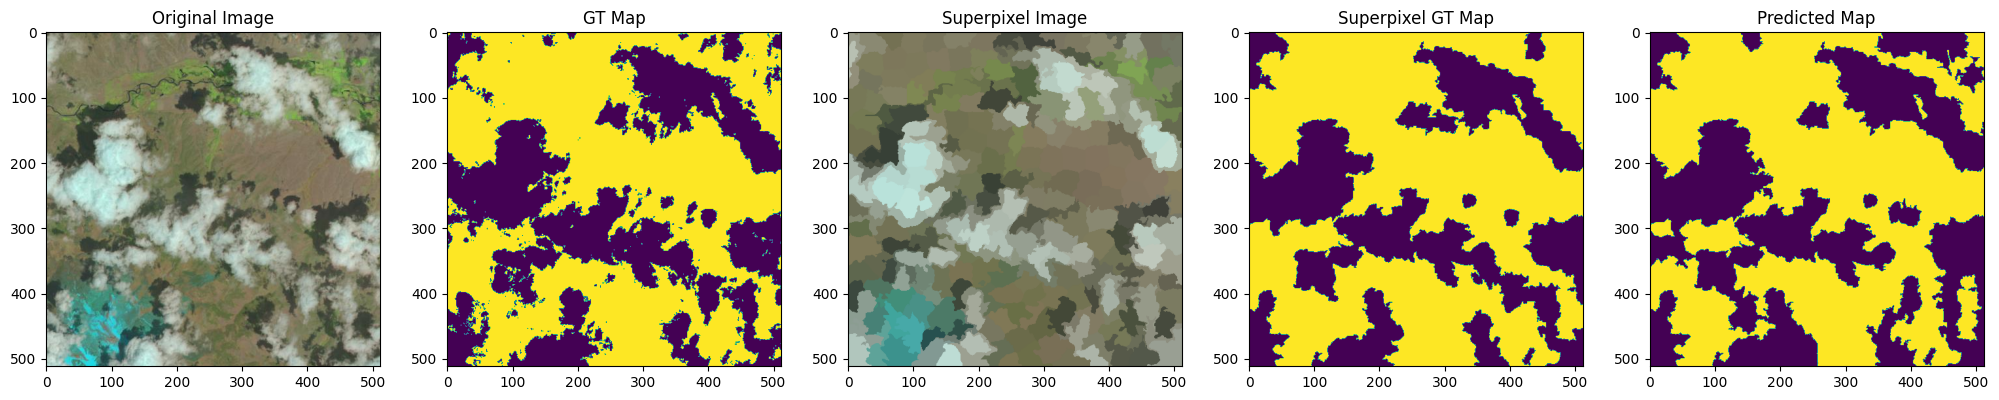

In [91]:
##plot segmented_image_rgb
i = 656

y_true = data_utils.unpad_and_map(X[i],y[i],original_ordering[i],slic_map[i])
y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
y_pred = data_utils.unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
## Make a 1x3 subplot
fig, ax = plt.subplots(1, 5, figsize=(25, 10))

## Plot the original image
ax[0].imshow(patches[i])
ax[0].set_title('Original Image')

## Plot the true segmentation
ax[1].imshow(mask[i])
ax[1].set_title('GT Map')

## Plot the superpixel segmentation
ax[2].imshow(raw[i])
ax[2].set_title('Superpixel Image')

## Plot the true segmentation
ax[3].imshow(y_true)
ax[3].set_title('Superpixel GT Map')

## Plot the predicted segmentation
ax[4].imshow(y_pred)
ax[4].set_title('Predicted Map')

## Show the plot
plt.show()

### Calculate DICE and Jaccaard Index

In [67]:
## Write a function to calculate the dice score between two images
def get_jaccard_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    jaccard = np.sum(intersection) / np.sum(union)
    return jaccard

def get_dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice


### SLIC

In [68]:
pred_maps = []
true_maps = []
for i in tqdm(test_index):
    y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
    pred = data_utils.unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
    pred_maps.append(pred)

    true = data_utils.unpad_and_map(X[i],y[i],original_ordering[i],slic_map[i])
    true_maps.append(true)

dice = []
for i,j in tqdm(zip(np.array(pred_maps),np.array(true_maps))):
    dice.append(get_dice_score(i,j))

jaccard = []
for i,j in tqdm(zip(np.array(pred_maps),np.array(true_maps))):
    jaccard.append(get_jaccard_score(i,j))

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [69]:
print("SLIC Dice:", np.mean(dice))
print("SLIC Jaccard:", np.mean(jaccard))

SLIC Dice: 0.8515107297416846
SLIC Jaccard: 0.7847100282799573


### Overall

In [70]:
pred_maps = []
for i in tqdm(test_index):
    y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
    pred = data_utils.unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
    pred_maps.append(pred)

dice = []
for i,j in tqdm(zip(np.array(pred_maps),mask[test_index])):
    dice.append(get_dice_score(i,j))

jaccard = []
for i,j in tqdm(zip(np.array(pred_maps),mask[test_index])):
    jaccard.append(get_jaccard_score(i,j))

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [71]:
print("Overall Dice:", np.mean(dice))
print("Overall Jaccard:", np.mean(jaccard))

Overall Dice: 0.824844499635953
Overall Jaccard: 0.7454739923077625
